In [120]:
# -*- coding: utf-8 -*-

In [121]:
from __future__ import division
from __future__ import print_function
from IPython.display import Audio
%matplotlib inline
from IPython.display import display
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

In [122]:
%run "speechutils.py"
%run "viewutils.ipynb"

In [123]:
ch = callhome_eval_init("config.json", fast=False, alpha=.1)
df_zrt, cols_to_show = ch.gen_zrt_df()

../../ZRTools/exp/callhome_train_50/matches/config0.80-0.90-0.80-50/master_graph.nodes
Loading prep state dictionary ...
Finished loading prep state dictionary ...
Finished ...
Processing line: 100000
Processing line: 200000
Processing line: 300000
Processing line: 400000
Processing line: 500000
Processing line: 600000
Finished - reading nodes ...
Processing line: 1
Processing line: 100001
Processing line: 200001
Processing line: 300001
Finished - reading edges ...
Removing duplicates in pairs list
Set length: 125085 and List length: 313761
Generating vocabulary of English words ... 
Finished vocab ...
Generating initial belief over English translations
Processed 1 nodes
Processed 100001 nodes
Processed 200001 nodes
Processed 300001 nodes
Processed 400001 nodes
Processed 500001 nodes
Processed 600001 nodes
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Generating similarity between nodes based on English translations ...
Finishe

In [124]:
alpha = 0.4
ch.interpolate_sim(alpha)
df_zrt, cols_to_show = ch.gen_zrt_df()

Interpolating similarity matrix ...
Finished interpolating similarity matrix ...
Updating data frame ...
Finished updating data frame ...


# Analyse ZRT output

### Set up visualizations

In [125]:
def display_pair_and_plot_dtw(pair_id, tosave=False, \
                              offset_1=(0,-1), \
                              offset_2=(0,-1), \
                              n_labels=("pair 1", "node 1", "node 2"), phones=False):
    display(Audio(ch.play_pair_wav(pair_id)))

    pair_info = ch.eval_pairs_list[pair_id]
    node_1 = ch.node_dict[pair_info['n1']]
    node_2 = ch.node_dict[pair_info['n2']]


    wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
    wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"


    if not phones:
        es_words_1 = ch.es_words_dict[node_1.wav_fil]
        es_words_2 = ch.es_words_dict[node_2.wav_fil]
    else:
        es_words_1 = ch.es_phones_dict[node_1.wav_fil]
        es_words_2 = ch.es_phones_dict[node_2.wav_fil]
    #plot_name = "output/dtw_pair_1761_1762.pdf"
    # print(wav_1, wav_2)
    # print(es_words_1, es_words_2)
    wav_1_time = (node_1.start, node_1.end)
    wav_2_time = (node_2.start, node_2.end)
    plot_name = "output/{0:d}.pdf".format(pair_id)
    if not tosave:
        plot_name = ""
        
    plot_dtw(wav_1, wav_2, es_words_1, es_words_2, \
             wav_1_time, wav_2_time, pair_info['zrt_sim'], plot_name, \
             offset_1, offset_2, n_labels)

In [126]:
pd.options.display.float_format = '{:,.3f}'.format

In [127]:
# display(df_zrt.head(1))
# display(df_zrt[cols_to_show].head(1))
# print(df_zrt.columns)

## Pairs discovered

### Filter Pairs

In [128]:
# Pairs with no matches in ES transcripts or only ['sil','sp'] matches
df_no_mtch_sil_only = df_zrt[(df_zrt['no_mtch'] == True) | (df_zrt['sil_only'] == True)]
# Pairs only ['sil','sp'] matches
df_sil_only = df_zrt[(df_zrt['sil_only'] == True)]
# Pairs with no matches in ES transcripts, but no ['sil','sp'] detected
df_no_mtch_not_sil = df_zrt[(df_zrt['no_mtch'] == True) & (df_zrt['sil_only'] == False)]

# Pairs with ES words found for both nodes
df_valid = df_zrt[(df_zrt['no_mtch'] == False) & (df_zrt['sil_only'] == False)]

# Filtering two files:
# df_valid = df_valid[df_valid.apply(lambda row: remove_invalid_files(row), axis=1)]
# df_valid = df_valid[df_valid['dur'] > 600]

# out_t = PrettyTable(["Description", "# of pairs"], hrules=True)
out_t = PrettyTable(["Description", "# of pairs"])
out_t.align['Description'] = 'r'
out_t.add_row(["Total pairs", len(df_zrt)])
out_t.add_row(["With sil, sp, or no matches", len(df_no_mtch_sil_only)])
out_t.add_row(["Pairs with speech segments and ES words", len(df_valid)])
print(out_t)
# print(out_t.get_html_string())
df_goodish = df_valid[(df_valid['ES word match']==1)]
df_cnt_goodish = df_valid[(df_valid['ES cont match']==1)]
df_xspk_goodish = df_valid[(df_valid['ES word match']==1) & (df_valid['cross_spk']==True)]
df_cnt_xspk_goodish = df_valid[(df_valid['ES cont match']==1) & (df_valid['cross_spk']==True)]
print("Total good scores: %d, content good scores: %d" % (len(df_goodish), len(df_cnt_goodish)))
print("Total cross-speaker good scores: %d, cross-speaker content good scores: %d" % \
      (len(df_xspk_goodish), len(df_cnt_xspk_goodish)))


+-----------------------------------------+------------+
|                             Description | # of pairs |
+-----------------------------------------+------------+
|                             Total pairs |   125085   |
|             With sil, sp, or no matches |   67106    |
| Pairs with speech segments and ES words |   57979    |
+-----------------------------------------+------------+
Total good scores: 8701, content good scores: 3740
Total cross-speaker good scores: 4962, cross-speaker content good scores: 1193


In [ ]:
alpha = 0.1
ch.interpolate_sim(alpha)

ap_all = []
acc_all = []
ap_x = []
acc_x = []

for alpha in np.arange(0,1.1,.1):
    print(alpha)
    # Interpolate translation similarity
    ch.interpolate_sim(alpha)
    
    # Calculate avg precision, accuracy for all matches
    p_z, r_z, ir_z  = ch.eval_precision_recall(eval_col='cnt_es_w_sim', sim_col='sim mixed', cross_spk=False)
    ap_all.append(np.trapz(p_z[::-1], r_z[::-1]))
    acc_all.append(np.trapz(r_z[::-1], ir_z[::-1]))
    
    # Calculate avg precision, accuracy for cross-speaker matches
    p_x, r_x, ir_x  = ch.eval_precision_recall(eval_col='cnt_es_w_sim', sim_col='sim mixed', cross_spk=True)
    ap_x.append(np.trapz(p_x[::-1], r_x[::-1]))
    acc_x.append(np.trapz(r_x[::-1], ir_x[::-1]))

print([float("{0:.4f}".format(x)) for x in ap_all])
print([float("{0:.4f}".format(x)) for x in acc_all])
print([float("{0:.4f}".format(x)) for x in ap_x])
print([float("{0:.4f}".format(x)) for x in acc_x])

In [ ]:
_, _, _ = ch.eval_precision_recall(eval_col='cnt_es_w_sim', cross_spk=True)
_, _, _ = ch.eval_precision_recall(eval_col='cnt_es_w_sim', sim_col='sim mixed', cross_spk=True)

In [ ]:
eval_col='cnt_es_w_sim'
# eval_col='es_w_sim'

fig_pr, fig_roc = ch.miniplot_precision_recall(eval_col=eval_col, cross_spk=False)
#fig_pr.suptitle("Precision/Recall - 50 calls, energy based VAD", fontsize=24, y=1.02)
# fig_pr.gca().set_title("Precision/Recall - 20 calls, evad based VAD", \
#                        fontsize=24, y=1.02)
# fig_pr.tight_layout()
# # fiig = plt.gcf()
# fig_pr.savefig("output/train_20_evad_pr.pdf")
# fig_roc.gca().set_title("ROC curve - 20 calls, evad based VAD", \
#                         fontsize=24, y=1.02)
# fig_roc.tight_layout()
# fig_roc.savefig("output/train_20_evad_roc.pdf")

## Histogram - ZRT values

In [ ]:
df_valid[['ZRT']].plot(kind='hist', alpha=0.7)
df_valid[['sim mixed']].plot(kind='hist', alpha=0.7)
df_valid[['EN sim']].plot(kind='hist', alpha=0.7)

In [ ]:
df_valid[['dur']].plot(kind='hist', alpha=0.7, bins=200)

## Correlation between DTW and other metrics

In [ ]:
display(df_valid[['ZRT', 'EN sim']].corr())
display(df_valid[['ZRT', 'ES cont match']].corr())
display(df_valid[['EN sim', 'ES cont match']].corr())
display(df_valid[['en_w_cnt_count_sim_0', 'ES cont match']].corr())

In [ ]:
cnt = defaultdict(int)
for i, pair in enumerate(ch.eval_pairs_list):
    if pair['cnt_es_w_sim'] > 0:
        cnt[0] += 1
    if pair['en_w_cnt_count_sim_0'] > 0:
        cnt[1] += 1
    if pair['en_w_cnt_hgr_sim_0'] > 0 and pair['cnt_es_w_sim'] > 0:
        cnt[2] += 1
    if pair['en_w_cnt_hgr_sim_0'] == 0 and pair['cnt_es_w_sim'] > 0:
        cnt[3] += 1
    if pair['en_w_cnt_hgr_sim_0'] > 0 and pair['cnt_es_w_sim'] == 0:
        cnt[4] += 1
    if pair['en_w_cnt_hgr_sim_0'] > 0 and pair['cnt_es_w_sim'] == 0:
        cnt[4] += 1
    if pair['en_w_cnt_hgr_sim_0'] > 0 and pair['cnt_es_w_sim'] == 0 and pair['zrt_sim'] < 0.85:
        cnt[5] += 1
    if pair['cnt_es_w_sim'] > 0 and pair['zrt_sim'] > 0.88:
        cnt[6] += 1
    if pair['cnt_es_w_sim'] == 0 and pair['zrt_sim'] > 0.88:
        cnt[7] += 1

print(cnt)

# Long matches

In [42]:
print(67/214)
print(188/1355)
print(1304/10452)
print(3740/57979)

0.31308411215
0.138745387454
0.124760811328
0.0645061142828


In [43]:
long_dur_ms = 700
df_long_dur = df_valid[df_valid['dur'] >= long_dur_ms]
print("# of pairs with duration >= %dms : %d" % (long_dur_ms, len(df_long_dur)))
df_long_dur[cols_to_show].head(10)

# of pairs with duration >= 700ms : 358


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
77,79,80,0.908,DIFíCILES POR EJEMPLO,FILóCTETES POR EJEMPLO P,1,0.857,1,0.092,0.582,1.049.007,1.049.014
7114,388,626,0.883,sil LG,EXACTAMENTE,0,0.000,0,0.000,0.530,1.092.005,2.101.050
16545,626,626,0.889,EXACTAMENTE,EXACTAMENTE,1,1.000,1,0.000,0.889,2.101.050,2.101.050
16689,626,5352,0.864,EXACTAMENTE,sil ESTE,0,0.000,0,0.000,0.518,2.101.050,1.093.030
16921,626,41532,0.851,EXACTAMENTE,BUENO sp sil,0,0.000,0,0.000,0.511,2.101.050,1.056.124
16956,626,292706,0.904,EXACTAMENTE,sp YA sil,0,0.000,0,0.000,0.542,2.101.050,1.094.130
28564,1323,1324,0.932,EN DONDE,DONDE EN DONDE sp,1,0.778,0,0.000,0.932,1.049.040,1.049.040
28570,1329,1330,0.913,SIMPLEMENTE EXPONGO,SIMPLEMENTE,1,0.846,1,0.069,0.575,1.049.040,1.049.062
29815,2250,373994,0.903,ESTUDIANTES Y,DE,0,0.000,0,0.000,0.542,1.103.009,1.106.097
29816,2250,373996,0.897,ESTUDIANTES Y,DE,0,0.000,0,0.000,0.538,1.103.009,1.106.097


In [ ]:
nodes_table = PrettyTable(["Node id", "Speech file", \
                           "Start time(ms)", \
                           "End time(ms)"])
transcripts_table = PrettyTable(["Node id", "ES words", \
                           "ES content words"])

scores_table = PrettyTable(["Pair id", "Node 1", "Node 2", "DTW score", "ES content word match"])


# for i in range(1,5)+[27, 28, 61, 62, 64, 1761,1762]:
#     nodes_table.add_row([i, ch.node_dict[i].wav_fil+".wav", ch.node_dict[i].start, \
#                         ch.node_dict[i].end])
#     #print((' '.join(ch.node_dict[i].es_cnt_words).decode('utf-8')))
#     es_w = (' '.join(ch.node_dict[i].es_words).decode('utf-8'))
#     if ch.node_dict[i].es_cnt_words:
#         es_cnt_w = (' '.join(ch.node_dict[i].es_cnt_words).decode('utf-8')).strip()
#     else:
#         es_cnt_w = '---'
#     #print(i, set(ch.node_dict[i].es_cnt_words) - set(['sil', 'sp']))
#     es_w = es_w.replace('sil', '').replace('sp', '')
#     es_cnt_w = es_cnt_w.replace('sil', '').replace('sp', '')
#     transcripts_table.add_row([i, es_w, es_cnt_w])

# found = 0
# for i, pair in enumerate(ch.eval_pairs_list):
#     if found == 10:
#         break
#     if pair['cnt_es_w_sim'] > 0 or i<=2:
#         scores_table.add_row([i, pair['n1'], pair['n2'], pair['zrt_sim'], pair['cnt_es_w_sim']])
#         found += 1

# print(nodes_table)
# print(transcripts_table)
# print(scores_table)
# #print(' '.join(ch.node_dict[2].es_words))


# display(ch.eval_pairs_list[1])
# found = 0
# for i, pair in enumerate(ch.eval_pairs_list):
#     if pair['zrt_sim'] >= 0.88 and len(pair['es_w_n1'].split()) >= 1 \
#     and pair['en_w_hgr_sim_0'] == 0 \
#     and pair['sil_only'] == False \
#     and pair['uid1'] != pair['uid2']:
#         print(i, pair['n1'], pair['n2'], \
#               pair['es_w_n1'].decode('utf-8'), pair['es_w_n2'].decode('utf-8'),\
#              pair['cnt_es_w_sim'])
#         found += 1
#         if found == 5:
#             break
# print(found)


# found = 0
# for i, pair in enumerate(ch.eval_pairs_list):
#     if pair['dur'] >= 100 \
#     and pair['en_w_hgr_sim_0'] == 0 and pair['sil_only'] == True:
#         print(i, pair['n1'], pair['n2'], \
#               pair['es_w_n1'].decode('utf-8'), pair['es_w_n2'].decode('utf-8'),\
#              pair['cnt_es_w_sim'])
#         found += 1
#         if found == 5:
#             break
# print(found)

In [ ]:
print(ch.eval_pairs_list[0].keys())

In [ ]:
nodes_list = []
for i, pair in enumerate(ch.eval_pairs_list):
    nodes_list.append(pair['n1'])
    nodes_list.append(pair['n2'])

n = len(nodes_list)
print('Number of nodes: %d' % n)
olap_vals = []
for i in xrange(n-1):
    if i % 1000 == 0:
        print(i, sep=', ', end=', ')
    for j in xrange(i+1,n):
        olap_vals.append(ch.calc_node_overlap(nodes_list[i],nodes_list[j]))
    

In [ ]:
olap_vals = np.array(olap_vals, dtype=np.float)
print("\nMean: %0.3f" % np.mean(olap_vals))

In [ ]:
cPickle.dump(olap_vals, open('olap_20_avad_vals.np', "wb"))

In [ ]:
olap_50_evad_mean = 0.056
olap_20_avad_mean = 0.077

In [ ]:
%run viewutils.ipynb
display_pair_and_plot_dtw(963, tosave=False, \
                          offset_1=(0,None), \
                          offset_2=(0,None), \
                          n_labels=("Pair 5", "segment 9", "segment 10"),phones=False)

# %run viewutils.ipynb
# display_pair_and_plot_dtw(15, tosave=False, \
#                           offset_1=(55,61), \
#                           offset_2=(150,156), \
#                           n_labels=("Pair 5", "segment 9", "segment 10"))

print(' '.join(ch.en_cnt_words_dict[ch.node_dict[180].wav_fil]))
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[1674].wav_fil]))
print(' '.join(ch.node_dict[180].es_cnt_words))
print(' '.join(ch.node_dict[1674].es_cnt_words))

In [ ]:
display(Audio(ch.play_pair_wav(15, detail=True)))

In [ ]:
display(Audio(ch.play_node_wav(20)))
# display(Audio('../../corpora/callhome_es/out/lala.wav'))
# display(Audio(ch.play_node_source_wav(12)))
for i, val in enumerate(ch.es_words_dict['050.048']):
    print(i, val.start)

In [ ]:
display(Audio(ch.play_pair_wav(34)))
display(Audio(ch.play_pair_wav(5119)))

In [ ]:
display(ch.play_node_wav(619))
display(ch.play_node_wav(620))
display(ch.play_node_wav(45))
display(ch.play_node_wav(46))

node_1_file = ch.play_node_wav(1761)
node_2_file = ch.play_node_wav(1762)
display(node_1_file)
display(node_2_file)
# display(ch.play_node_source_wav(76605))

In [ ]:
plot_dtw(node_1_file, node_2_file)

In [ ]:
%run viewutils.ipynb
node_id = 1761

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1761.pdf"

plot_specgram_words(target_file, es_words, plot_name, offset=(0,10))

print(ch.en_words_dict[wav_file])

In [ ]:
node_id = 1762

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1762.pdf"

plot_specgram_words(target_file, es_words, plot_name, offset=(0,12))

print("English translation:\n%s" % ' '.join(ch.en_words_dict[wav_file]))

In [ ]:
2680-1710

In [ ]:
display(Audio(ch.play_pair_wav(5118)))

In [ ]:
# %run viewutils.ipynb

# node_1 = ch.node_dict[1761]
# node_2 = ch.node_dict[1762]

# wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
# wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"

# es_words_1 = ch.es_words_dict[node_1.wav_fil]
# es_words_2 = ch.es_words_dict[node_2.wav_fil]
# plot_name = "output/dtw_pair_1761_1762.pdf"
# # print(wav_1, wav_2)
# # print(es_words_1, es_words_2)
# wav_1_time = (node_1.start, node_1.end)
# wav_2_time = (node_2.start, node_2.end)
# plot_dtw(wav_1, wav_2, es_words_1, es_words_2, \
#          wav_1_time, wav_2_time, plot_name)

In [116]:
%run viewutils.ipynb

In [117]:
tosave=False

In [118]:
def plot_labels(n1_l, n2_l, dtw):
    ax = plt.gca()
    

Playing evaluation pair id: 5118
Pair text details
+---------+----------------------+-----------------------------------------------+
| node id |    ES transcript     |                 EN translation                |
+---------+----------------------+-----------------------------------------------+
|   1761  | ACTA DE BAUTISMO sil |     to tell them to send me my baptism act    |
+---------+----------------------+-----------------------------------------------+
|   1762  | ACTA DE BAUTISMO sil | we are going to need the sacrament of baptism |
|         |                      |                     paper                     |
+---------+----------------------+-----------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.933       |
+-----------------

MI ACTA DE BAUTISMO sil
DEL ACTA DE BAUTISMO sil
DTW distance: 54.530782
tell send baptism act
going need sacrament baptism paper
ACTA BAUTISMO sil
ACTA BAUTISMO sil


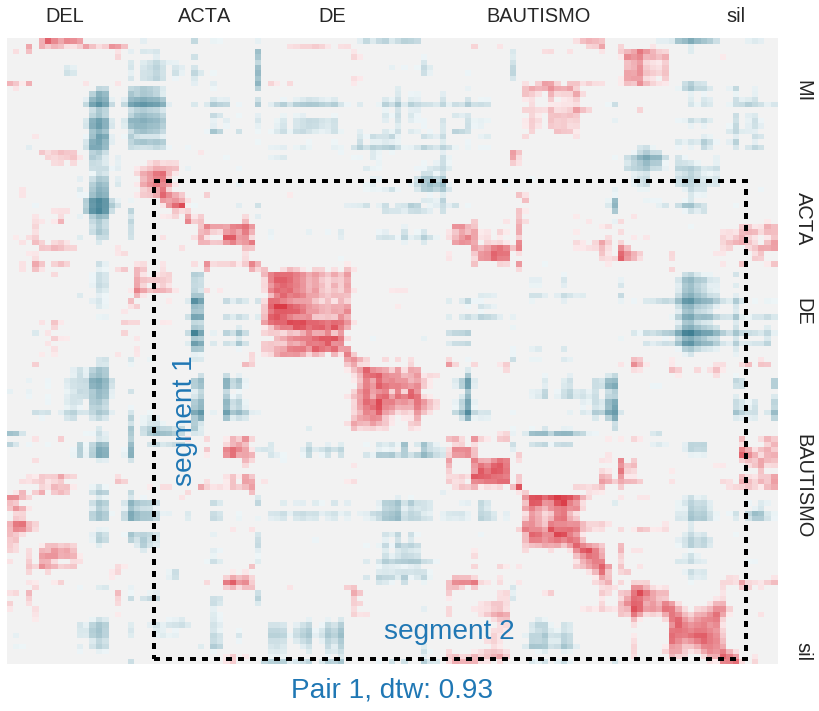

In [119]:
%run viewutils.ipynb
display_pair_and_plot_dtw(5118, tosave=tosave, \
                          offset_1=(6,None), \
                          offset_2=(8,None), \
                          n_labels=("Pair 1", "segment 1", "segment 2"))

print(' '.join(ch.en_cnt_words_dict[ch.node_dict[1761].wav_fil]))
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[1762].wav_fil]))
print(' '.join(ch.node_dict[1761].es_cnt_words))
print(' '.join(ch.node_dict[1762].es_cnt_words))

In [ ]:
display_pair_and_plot_dtw(15944, tosave=tosave, \
                          offset_1=(4,-2), \
                          offset_2=(3,-2), \
                          n_labels=("Pair 2", "segment 3", "segment 4"))

print(' '.join(ch.en_cnt_words_dict[ch.node_dict[33935].wav_fil]))
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[33936].wav_fil]))
print(' '.join(ch.node_dict[33935].es_cnt_words))
print(' '.join(ch.node_dict[33936].es_cnt_words))

In [ ]:
print(ch.en_w_cnt_belief[44099])
print(' & '.join([ch.i2w[w] for w in ch.en_w_cnt_belief[44099]]))
print(' & '.join(["{0:.2f}".format(b) for b in ch.en_w_cnt_belief[44099].values()]))

print([ch.i2w[w] for w in ch.en_w_cnt_belief[44100]])
print(["{0:.2f}".format(b) for b in ch.en_w_cnt_belief[44100].values()])

In [ ]:
display_pair_and_plot_dtw(16848, tosave=tosave, \
                          offset_1=(6,9), \
                          offset_2=(1,4), \
                          n_labels=("Pair 3", "segment 5", "segment 6"))

print(ch.node_dict[44099].es_cnt_words)
print(ch.node_dict[44100].es_cnt_words)
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[44099].wav_fil]))
print(' '.join(ch.en_cnt_words_dict[ch.node_dict[44100].wav_fil]))
print(' '.join(ch.node_dict[44099].es_cnt_words))
print(' '.join(ch.node_dict[44100].es_cnt_words))

In [ ]:
display_pair_and_plot_dtw(19326, tosave=tosave, \
                          offset_1=(0,3), \
                          offset_2=(0,3), \
                          n_labels=("pair 4", "node 7", "node 8"))

## Callhome 50, evad

In [ ]:
display_pair_and_plot_dtw(817, tosave=False)

### High phoneme score

In [ ]:
df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.6) \
                            & (df_valid['EN sim'] == 0)]
print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_hi[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score >= 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi[cols_to_show].head(5)

In [ ]:
display(Audio(ch.play_pair_wav(75)))

## Low phoneme score

In [ ]:
df_phone_score_0 = df_valid[(df_valid['ES phone edit sim'] == 0)]
print("Pairs with 0 phoneme similarity score: %d" % len(df_phone_score_0))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_0[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score = 0', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

** Analysis:** The plot shows a lot of high DTW score pairs where there is no match in the phonemes

In [ ]:
df_phone_score_0_high_dtw = df_phone_score_0[df_phone_score_0['ZRT'] > 0.87]
print("Pairs with high DTW and 0 phoneme similarity score: %d" % len(df_phone_score_0_high_dtw))

display(df_phone_score_0_high_dtw[cols_to_show].head(3))
# ch.play_pair_wav(28)

In [ ]:
df_phone_score_0_en_score_0 = df_phone_score_0[df_phone_score_0['EN sim'] == 0]
print("Pairs with 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_en_score_0))
# display(df_phone_score_0_en_score_0[cols_to_show][df_phone_score_0_en_score_0['ZRT'] < 0.82].head(3))
display(df_phone_score_0_en_score_0[cols_to_show].head(3))

df_phone_score_0_high_dtw_en_score_0 = df_phone_score_0_high_dtw[df_phone_score_0_high_dtw['EN sim'] == 0]
print("Pairs with high DTW and 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_high_dtw_en_score_0))
display(df_phone_score_0_high_dtw_en_score_0[cols_to_show].head(3))

In [ ]:
# display(ch.play_pair_wav(594, detail=True))
display(ch.play_pair_wav(52, detail=False))
# display(ch.play_node_source_wav(131))

In [ ]:
ch.file_info_dict["049.156"].source_file

In [ ]:
# !soxi ../../corpora/callhome_es/out/006.183.wav
# !play ../../corpora/callhome_es/out/006.183.wav trim 1.24
# IPython.display.Audio("../../corpora/callhome_es/out/tmp/sp_0731_1.wav")

### Conclusion

**Pairs with high DTW and 0 phoneme and 0 EN word similarity indicate transcription errors or coding errors**


**Need to investigate**

### High Phoneme similarity

In [ ]:
# df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.5)]
# print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_valid['ZRT'].hist(ax=ax, alpha=0.3)
df_phone_score_hi['ZRT'].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score > 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi_en_score_0 = df_phone_score_hi[(df_phone_score_hi['EN sim'] == 0) & \
                                                (df_phone_score_hi['spk1'] != df_phone_score_hi['spk2'])]
print("Pairs with high phoneme score and 0 EN sim: %d" % len(df_phone_score_hi_en_score_0))

df_phone_score_hi_en_score_0[cols_to_show].head(5)

In [ ]:
ch.play_pair_wav(70)

## High DTW score, Low EN translation similarity

These are expected to be phonetically similary but semantically different pairs.

**Label Spreading** should help **lower** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] == 0)].hist()
print(len(df_valid['ZRT'][(df_valid['EN sim'] == 0)]))

In [ ]:
df_high_dtw_0_en = df_valid[(df_valid['ZRT'] > 0.87) \
                            & (df_valid['EN sim'] >= 0.2) & \
                            (df_valid['spk1'] != df_valid['spk2'])]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_high_dtw_0_en))
df_high_dtw_0_en[cols_to_show].head(5)

In [ ]:
display(Audio(ch.play_pair_wav(105, detail=True)))

In [ ]:
# !play ../../corpora/callhome_es/out/001.202.wav trim .75 =.99

## Low DTW score, High EN translation similarity

These are expected to be semantically similar but phonetically not very similar.

**Label Spreading** should help **increase** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] >= 0.2)].hist()

In [ ]:
df_low_dtw_high_en = df_valid[(df_valid['ZRT'] < 0.88) & (df_valid['EN sim'] >= 0.2)]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_low_dtw_high_en))
df_low_dtw_high_en[cols_to_show].tail()

In [ ]:
display(Audio(ch.play_pair_wav(19326, detail=True)))

## Precision / Recall

In [ ]:
df_valid[cols_to_show].head()

In [134]:
alpha = 0.4
ch.interpolate_sim(alpha)
df_zrt, cols_to_show = ch.gen_zrt_df()

Interpolating similarity matrix ...
Finished interpolating similarity matrix ...
Updating data frame ...
Finished updating data frame ...


In [48]:
ch.eval_precision_recall()

Computing precision recall, cross speaker = 0
# eval scores: 57979
# good scores: 3740
#  bad scores: 54239
Average Precision - using sim: zrt_sim
----------------------------------------
	0.14489
----------------------------------------
Accuracy - using sim: zrt_sim
----------------------------------------
	0.50000
----------------------------------------


(array([ 0.06450611,  0.06450611,  0.06451056,  0.06451279,  0.06451724,
         0.0645306 ,  0.06454564,  0.06463661,  0.06489532,  0.06560875,
         0.06743253,  0.07082479,  0.07691468,  0.08688902,  0.10106193,
         0.1173727 ,  0.13657381,  0.15609056,  0.17412441,  0.18560372,
         0.18935562,  0.18793212,  0.18469896,  0.16192412,  0.14271152,
         0.12162162,  0.0989011 ,  0.07534247,  0.06914894,  0.08130081,
         0.10344828,  0.15517241,  0.20930233,  0.29032258,  0.33333333,
         0.39130435,  0.47368421,  0.57142857,  0.66666667,  0.55555556,
         0.55555556,  0.        ]),
 array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  0.99973262,  0.99946524,  0.99786096,  0.99491979,
         0.98877005,  0.97005348,  0.94144385,  0.89786096,  0.83208556,
         0.73342246,  0.63181818,  0.52352941,  0.42139037,  0.32058824,
         0.2302139 ,  0.15989305,  0.10909091,  0.06390374,  0.03743316,
         0.0216

In [ ]:
ch.eval_precision_recall(sim_col='sim mixed')

Computing precision recall, cross speaker = 0
# eval scores: 57979
# good scores: 3740
#  bad scores: 54239
Average Precision - using sim: zrt_sim
----------------------------------------
	0.14489
----------------------------------------
Accuracy - using sim: zrt_sim
----------------------------------------
	0.73174
----------------------------------------
Computing precision recall, cross speaker = 0
# eval scores: 57979
# good scores: 3740
#  bad scores: 54239
Average Precision - using sim: sim mixed
----------------------------------------
	0.42131
----------------------------------------
Accuracy - using sim: sim mixed
----------------------------------------
	0.83550
----------------------------------------


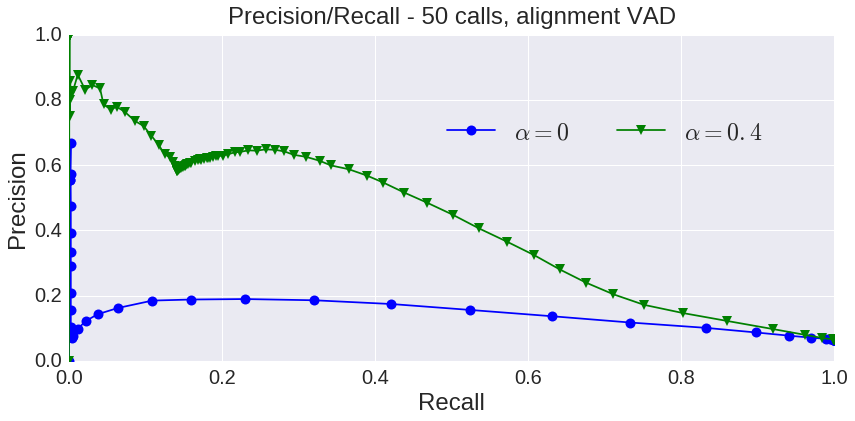

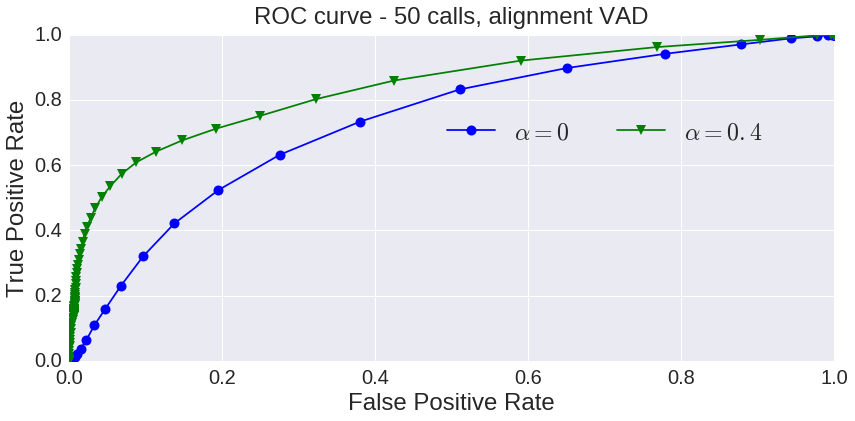

In [139]:
eval_col='cnt_es_w_sim'
# eval_col='es_w_sim'

fig_pr, fig_roc = ch.miniplot_precision_recall(eval_col=eval_col, cross_spk=False, alpha=0.4)
fig_pr.gca().set_title("Precision/Recall - 50 calls, alignment VAD", \
                       fontsize=24, y=1.02)
fig_pr.gca().legend(loc='upper center', bbox_to_anchor=(0.7, 0.8),
                  ncol=2, fancybox=True, shadow=True, fontsize=24)
fig_pr.gca().set_ylabel("Precision", fontsize=24)
fig_pr.gca().set_xlabel("Recall", fontsize=24)
fig_pr.tight_layout()
# fiig = plt.gcf()
fig_pr.savefig("output/train_50_avad_pr.pdf")
fig_roc.gca().set_title("ROC curve - 50 calls, alignment VAD", \
                        fontsize=24, y=1.02)
fig_roc.gca().legend(loc='upper center', bbox_to_anchor=(0.7, 0.8),
                  ncol=2, fancybox=True, shadow=True, fontsize=24)
fig_roc.gca().set_ylabel("True Positive Rate", fontsize=24)
fig_roc.gca().set_xlabel("False Positive Rate", fontsize=24)
fig_roc.tight_layout()
fig_roc.savefig("output/train_50_avad_roc.pdf")

## Cross-utterance matches

In [ ]:
set_speakers_calls = set()
spk1_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk1'].values]
spk2_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk2'].values]
set_speakers_calls |= set(spk1_ids)
set_speakers_calls |= set(spk2_ids)

num_speakers = len(set_speakers_calls)
cross_spk_counts = np.zeros((num_speakers, num_speakers), dtype=np.int)
label2i = {k:i for i, k in enumerate(set_speakers_calls)}
i2label = {i:k for i, k in enumerate(set_speakers_calls)}

lol = 0
for spk1, spk2 in zip(spk1_ids, spk2_ids):
    if spk1 != spk2:
        lol += 1
        cross_spk_counts[max(label2i[spk1], label2i[spk2]), min(label2i[spk1], label2i[spk2])] += 1
        cross_spk_counts[min(label2i[spk1], label2i[spk2]), max(label2i[spk1], label2i[spk2])] += 1
    else:
        cross_spk_counts[label2i[spk1], label2i[spk2]] += 1
        pass

print("Total speakers: %d" % num_speakers)
print(lol)

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    ax = sns.heatmap(cross_spk_counts, square=True, annot=False, \
                 fmt="d", linewidths=.5, cbar=False, xticklabels=2, yticklabels=2)
ax.xaxis.tick_top()
# f.savefig("output/train_20_only_cross_spkrs.pdf")
# f.savefig("output/train_20_only_cross_spkrs.png")

In [ ]:
# df_valid.columns
df_cross_spkr = df_valid[df_valid.apply(lambda row: True if row['spk1'].rsplit('.', 1)[0] != \
                        row['spk2'].rsplit('.', 1)[0] else False, \
                                    axis=1)]
print("# of cross-speaker pairs: %d" % (len(df_valid[df_valid['cross_spk'] == True])))
# display(df_valid[cols_to_show].head(5))
#df_cross_spkr['ZRT'].hist()
# df_valid['cross_spk'] = 
print(len(df_cross_spkr), len(df_valid))

In [ ]:
df_cross_spkr_bad_zrt_good_en = df_cross_spkr[(df_cross_spkr['ZRT'] <= 0.87)\
                                              & (df_cross_spkr['EN sim'] > 0.2)]
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr_bad_zrt_good_en)))
display(df_cross_spkr_bad_zrt_good_en[cols_to_show].head(10))

In [ ]:
display(Audio(ch.play_pair_wav(16848)))

## Speakers/utterances with most matches

In [ ]:
df_spkr_matches = df_valid.apply(lambda row: row['spk1'].rsplit('.', 1)[0] != \
                                   row['spk2'].rsplit('.', 1)[0], \
                                   axis=1)
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr)))
display(df_cross_spkr[cols_to_show].head(3))
df_cross_spkr['ZRT'].hist()

## Label Spreading - speech pair similarity score update using English translations

In [ ]:
ch.label_prop_edges.label_spread(ch.en_w_hgr_sim_0)

In [ ]:
print(ch.label_prop_edges.belief_0[1])
print(ch.label_prop_edges.belief_n[1])
print(ch.en_w_hgr_sim_0[1], ch.en_w_hgr_sim_0[2])

In [ ]:
df_valid[cols_to_show].sort_values(['ZRT'], ascending=False)

In [ ]:
display(ch.play_pair_wav(84, detail=True))

In [ ]:
(0.9 * 0.8) + (0.1 * 0.7)

In [ ]:
df_valid.columns

In [ ]:
sns.jointplot(x='ZRT', y='ES cont match', data=df_valid, kind='kde')

In [ ]:
df_valid.columns

In [ ]:
%run viewutils.ipynb

In [ ]:
# plot_hist_dtw(df_valid, plot_name="output/train_20_energy_vad_hist.pdf")
# plot_hist_dtw(df_valid, plot_name="output/train_20_transcript_vad_hist.pdf")

In [ ]:
%%timeit -n1 -r1
ch_eval.label_prop_en_words.label_spread(ch_eval.edges_dict)
print(ch_eval.edges_dict[1])
print(ch_eval.en_w_belief[1])
print(ch_eval.en_w_belief[2])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])

print(len(ch_eval.en_vocab))
print(sorted(ch_eval.en_words_stats.items(), reverse=True, key= lambda x: x[1])[:5])
print(ch_eval.en_w_sim_0[1])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])
print(ch_eval.label_prop_en_words.belief_0[2])
print(ch_eval.label_prop_en_words.belief_n[2])

Trying line plots for metrics

In [ ]:
N = 4
no_trans = (0.69, 0.37, 0.268, 0.144)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, no_trans, width, color=tableau20[1])

with_trans = (0.79, 0.58, 0.484, 0.328)
rects2 = ax.bar(ind + width, with_trans, width, color=tableau20[0])

# add some text for labels, title and axes ticks
ax.set_ylabel('Average Precision', size=16)
ax.set_title('Average Precision, with & without translations', size=15)
ax.set_xticks(ind + width)
ax.set_xticklabels(('20:energy', '50:energy', '20:align', '50:align'), size=16)
ax.set_ylim(0.0,1.0)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(16)

ax.legend((rects1[0], rects2[0]), ('without translations', 'with translations'), fontsize=14)
fig.savefig("output/avgprecision.pdf")


In [ ]:
N = 4
no_trans = (0.01866, 0.02533, 0.01133, 0.02178)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, no_trans, width, color=tableau20[1])

with_trans = (0.02408, 0.03209, 0.01368, 0.02579)
rects2 = ax.bar(ind + width, with_trans, width, color=tableau20[0])

# add some text for labels, title and axes ticks
ax.set_ylabel('Average Precision', size=16)
ax.set_title('Cross-Speaker Average Precision, with & without translations', size=15, y=1.08)
ax.set_xticks(ind + width)
ax.set_xticklabels(('20:energy', '50:energy', '20:align', '50:align'), size=16)
ax.set_ylim(0.0,0.1)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(16)

ax.legend((rects1[0], rects2[0]), ('without translations', 'with translations'), fontsize=14)
fig.tight_layout()

fig.savefig("output/x_spkr_avgprecision.pdf")



In [10]:
 def format_metrics_plot(ax, fig, title, plotname='', showlegend=False):
    ax.set_ylabel(title, size=18)
    #ax.set_title(r'Metrics - varying $\alpha$', size=15, y=1.08)
    #ax.set_title(title, size=15, y=1.02)
    ax.set_xlabel('Translation similarity utilised', size=15)
    ax.set_xticklabels(["{0:d}%".format(int(x*100.0)) for x in alpha], size=15)
    ax.set_xticks(alpha)
    plt.xticks(rotation=60)
    ax.set_xlim(0,1)
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14)
#     if showlegend:
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98),
#                   ncol=2, fancybox=True, shadow=True, fontsize=14)
    fig.tight_layout()
    if plotname:
        fig.savefig(plotname)

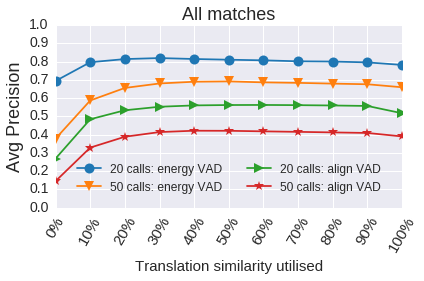

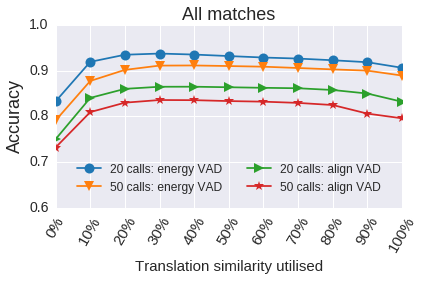

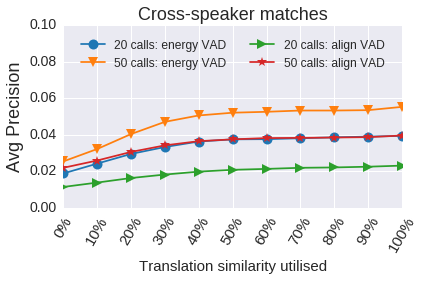

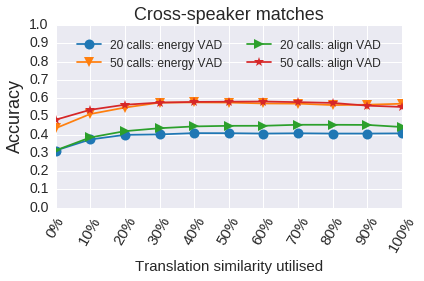

In [91]:
#### N = 4
alpha =  np.arange(0,1.1,0.1)
avg_precision_50_align_vad = np.array([0.144, .328, 0.388, 0.41383, 0.42131, \
                              0.42083, 0.41784, 0.41495, 0.41197, 0.40896, 0.38993])

avg_precision_50_energy_vad = np.array([0.37782, 0.58698, 0.65583, 0.68022, 0.68980, 0.69156, \
                               0.68633, 0.68359, 0.67942, 0.67588, 0.65945])

# ----------------------------------------------------------------------------------------------------------------
# 20 files: energy vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_evad = np.array([0.694, 0.7967, 0.814, 0.8195, 0.8144, 0.8105, 0.8071, 0.8018, 0.8004, 0.7958, 0.7819])
acc_20_evad = np.array([0.8328, 0.9195, 0.9351, 0.9377, 0.9355, 0.9322, 0.929, 0.9267, 0.923, 0.9187, 0.9065])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_evad_x = np.array([0.0187, 0.0241, 0.0294, 0.0332, 0.0362, 0.0374, 0.0375, 0.038, 0.0385, 0.0389, 0.0393])
acc_20_evad_x = np.array([0.3124, 0.3732, 0.3986, 0.401, 0.4081, 0.4077, 0.4057, 0.4072, 0.4057, 0.4057, 0.4067])
# ----------------------------------------------------------------------------------------------------------------
# 50 files: energy vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_evad = np.array([0.3778, 0.587, 0.6558, 0.6802, 0.6898, 0.6916, 0.6863, 0.6836, 0.6794, 0.6759, 0.6594])
acc_50_evad = np.array([0.791, 0.8776, 0.9019, 0.9113, 0.9116, 0.9103, 0.9089, 0.906, 0.903, 0.9002, 0.8894])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_evad_x = np.array([0.0253, 0.0321, 0.0403, 0.047, 0.0505, 0.052, 0.0525, 0.0532, 0.0532, 0.0534, 0.0552])
acc_50_evad_x = np.array([0.4346, 0.5127, 0.5481, 0.5752, 0.5765, 0.5756, 0.5707, 0.5697, 0.5618, 0.5639, 0.5692])
# ----------------------------------------------------------------------------------------------------------------
# 20 files: align vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_avad = np.array([0.2687, 0.4842, 0.5334, 0.5526, 0.56, 0.5621, 0.5625, 0.5614, 0.5596, 0.557, 0.5169])
acc_20_avad = np.array([0.7499, 0.8405, 0.8603, 0.8649, 0.865, 0.8638, 0.8626, 0.8616, 0.8578, 0.85, 0.832])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_20_avad_x = np.array([0.0113, 0.0137, 0.0162, 0.0181, 0.0197, 0.0207, 0.0212, 0.0218, 0.022, 0.0224, 0.023])
acc_20_avad_x = np.array([0.3133, 0.3843, 0.4189, 0.435, 0.4448, 0.4481, 0.4483, 0.4539, 0.4538, 0.4531, 0.4416])
# ----------------------------------------------------------------------------------------------------------------
# 50 files: align vad
# ----------------------------------------------------------------------------------------------------------------
# all matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_avad = np.array([0.1449, 0.3287, 0.3882, 0.4138, 0.4213, 0.4208, 0.4178, 0.415, 0.412, 0.409, 0.3899])
acc_50_avad = np.array([0.7317, 0.8093, 0.83, 0.8358, 0.8355, 0.8335, 0.8322, 0.8295, 0.8248, 0.806, 0.7957])
# ----------------------------------------------------------------------------------------------------------------
# cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
ap_50_avad_x = np.array([0.0218, 0.0258, 0.0305, 0.0341, 0.0364, 0.0374, 0.0381, 0.0382, 0.0384, 0.0386, 0.0395])
acc_50_avad_x = np.array([0.4813, 0.5359, 0.5636, 0.5755, 0.5791, 0.5803, 0.5814, 0.5779, 0.5736, 0.5586, 0.5516])
# ----------------------------------------------------------------------------------------------------------------
# Plots
# ----------------------------------------------------------------------------------------------------------------
markers = ["o","v",">",'*']
labels = ['20 calls: energy VAD', '50 calls: energy VAD', '20 calls: align VAD', '50 calls: align VAD']
colors = [0, 2, 4, 6]
titles = ["Avg Precision", "Accuracy", \
          "Avg Precision", "Accuracy"]
plot_names = ["output/ap_all.pdf", "output/acc_all.pdf", \
              "output/ap_x.pdf", "output/acc_x.pdf"]
fig_size = (6,4)
ap_arrays = [ap_20_evad, ap_50_evad, ap_20_avad, ap_50_avad]
acc_arrays = [acc_20_evad, acc_50_evad, acc_20_avad, acc_50_avad]
ap_x_arrays = [ap_20_evad_x, ap_50_evad_x, ap_20_avad_x, ap_50_avad_x]
acc_x_arrays = [acc_20_evad_x, acc_50_evad_x, acc_20_avad_x, acc_50_avad_x]
# ----------------------------------------------------------------------------------------------------------------
# Avg. Precision for all matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(ap_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], label=labels[i], markersize=10)
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0,1)
ax.set_title('All matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[0], plotname=plot_names[0], showlegend=True)
# ----------------------------------------------------------------------------------------------------------------
# Accuracy for all matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(acc_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], label=labels[i], markersize=10)
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0.6,1)
ax.set_title('All matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.3),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[1], plotname=plot_names[1], showlegend=True)
# ----------------------------------------------------------------------------------------------------------------
# Avg. Precision for cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(ap_x_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], label=labels[i], markersize=10)
ax.yaxis.set_major_locator(MultipleLocator(.02))
ax.set_ylim(0,0.1)
ax.set_title('Cross-speaker matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[2], plotname=plot_names[2], showlegend=True)
# ----------------------------------------------------------------------------------------------------------------
# Accuracy for cross-speaker matches
# ----------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=fig_size)
for i, arr_data in enumerate(acc_x_arrays):
    ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], label=labels[i], markersize=10)
ax.yaxis.set_major_locator(MultipleLocator(.1))
ax.set_ylim(0,1)
ax.set_title('Cross-speaker matches', size=18)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98),
                  ncol=2, fancybox=True, shadow=True, fontsize=12)
format_metrics_plot(ax, fig, titles[3], plotname=plot_names[3], showlegend=True)



In [27]:
for ap_arr, acc_arr in zip(ap_arrays, acc_arrays):
    #print(ap_arr[0],ap_arr[4])
    #print(acc_arr[0], acc_arr[4])
    print("& %.3f & %.3f & %.3f & %.3f \\\\" % (ap_arr[0], ap_arr[4], acc_arr[0], acc_arr[4]))
    


& 0.694 & 0.814 & 0.833 & 0.935 \\
& 0.378 & 0.690 & 0.791 & 0.912 \\
& 0.269 & 0.560 & 0.750 & 0.865 \\
& 0.145 & 0.421 & 0.732 & 0.836 \\


In [44]:
ch.eval_pairs_list[16545]

{'chid1': 2,
 'chid2': 2,
 'cnt_es_w_check': True,
 'cnt_es_w_sim': 1,
 'dur': 820,
 'en_w_cnt_count_sim_0': 0,
 'en_w_cnt_hgr_sim_0': 0,
 'en_w_count_sim_0': 0,
 'en_w_hgr_sim_0': 0,
 'es_p_sim': 1.0,
 'es_w_n1': 'EXACTAMENTE',
 'es_w_n2': 'EXACTAMENTE',
 'es_w_sim': 1,
 'n1': 626,
 'n2': 626,
 'no_mtch': False,
 'sil_only': False,
 'uid1': '101.050',
 'uid2': '101.050',
 'zrt_sim': 0.889}

In [106]:
(1-(1-(((1/3) * (1/2)) ** .5))**.5)

0.23074600453677396

In [ ]:
for no,yes in zip(no_trans, with_trans):
    print((yes-no) / no * 100)

Why are align VAD 50 matches less than forced VAD 20 matches, though there is more speech data

In [ ]:
wav_name = "sp_0897.wav"
# IPython.display.Audio(wav_name)
sr1, y1 = scipy.io.wavfile.read(wav_name)
print(len(y1) / sr1, len(y1) / sr1 / 60.0)
!soxi $wav_name
mfcc1 = mfcc(y1, sr1)
print(mfcc1.shape)

Plot links:

- http://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot


Bhattacharyya link:
http://www.cs.yorku.ca/~kosta/CompVis_Notes/bhattacharyya.pdf
